In [1]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from model import build_model, SIZE
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import numpy as np
import cv2
import os
import keras
from sklearn import metrics
import time

In [2]:
SIZE = 64
INPUT_SHAPE = (SIZE, SIZE, 3)


def build_model(filters=32, neurons1=512, neurons2=256):
    input = keras.layers.Input(INPUT_SHAPE)

    # Convo Block 1
    conv1 = keras.layers.Conv2D(filters, kernel_size=(3, 3),
                                activation='relu', padding='same')(input)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    norm1 = keras.layers.BatchNormalization(axis=-1)(pool1)
    drop1 = keras.layers.Dropout(rate=0.2)(norm1)

    # Convo Block 2
    conv2 = keras.layers.Conv2D(filters, kernel_size=(3, 3),
                                activation='relu', padding='same')(drop1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    norm2 = keras.layers.BatchNormalization(axis=-1)(pool2)
    drop2 = keras.layers.Dropout(rate=0.2)(norm2)

    # Flatten the matrix to get it ready for dense.
    flat = keras.layers.Flatten()(drop2)

    hidden1 = keras.layers.Dense(neurons1, activation='relu')(flat)
    norm3 = keras.layers.BatchNormalization(axis=-1)(hidden1)
    drop3 = keras.layers.Dropout(rate=0.2)(norm3)

    hidden2 = keras.layers.Dense(neurons2, activation='relu')(drop3)
    norm4 = keras.layers.BatchNormalization(axis=-1)(hidden2)
    drop4 = keras.layers.Dropout(rate=0.2)(norm4)

    out = keras.layers.Dense(2, activation='sigmoid')(drop4)

    model = keras.Model(inputs=input, outputs=out)
    model.compile(optimizer='adam',
              # Check between binary_crossentropy and categorical_crossentropy
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model


In [3]:
np.random.seed(1000)
os.environ['KERAS_BACKEND'] = 'tensorflow'

image_directory = '../data/cell_images/'
dataset = []
label = []

parasitized_images = os.listdir(image_directory + 'Infected/')
# Go thru every image and resize + add label.
for i, image_name in enumerate(parasitized_images):

    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Infected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)),
                                                    test_size=0.20, random_state=0)

In [4]:
model = build_model()
model.compile(optimizer='adam',
              # Check between binary_crossentropy and categorical_crossentropy
              loss='categorical_crossentropy',
              metrics=['accuracy'])

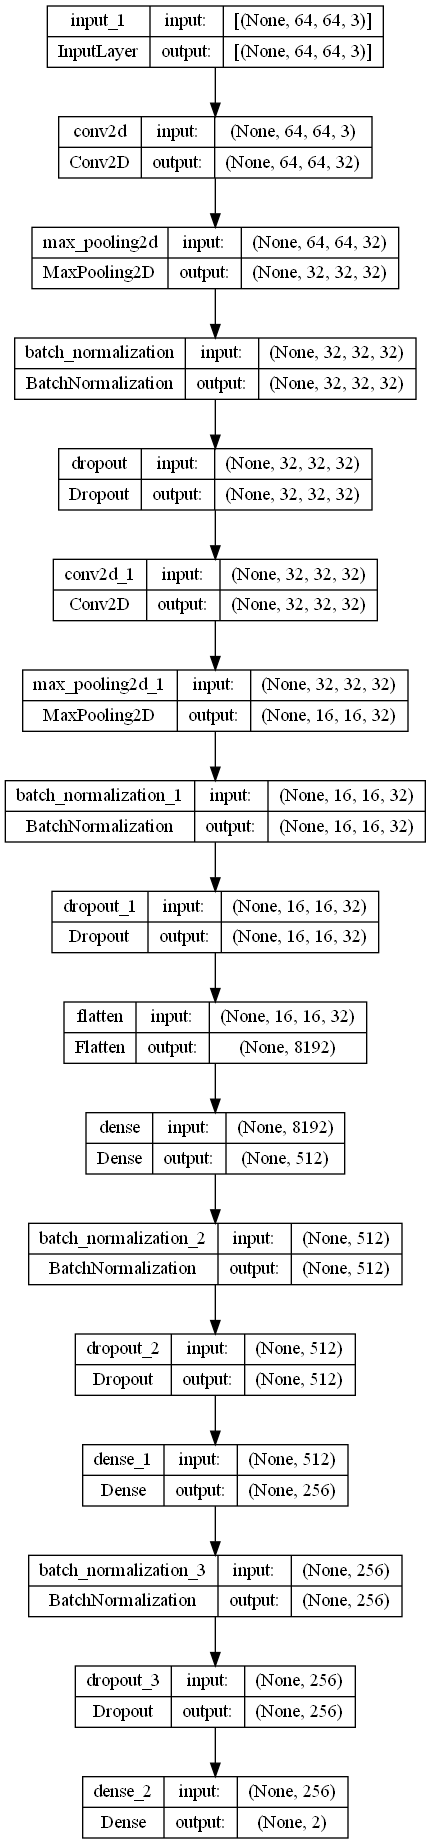

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='classify_model_CNN_plot.png',show_shapes=True)

In [7]:
history = model.fit(np.array(X_train),
                    y_train,
                    batch_size=64,
                    verbose=1,
                    epochs=3,
                    validation_split=0.1,
                    shuffle=False
                    )

Epoch 1/3
311/311 [==============================] - 28s 87ms/step - loss: 0.4870 - accuracy: 0.7888 - val_loss: 0.6434 - val_accuracy: 0.8490
Epoch 2/3
311/311 [==============================] - 24s 79ms/step - loss: 0.2315 - accuracy: 0.9133 - val_loss: 0.6542 - val_accuracy: 0.8494
Epoch 3/3
311/311 [==============================] - 24s 76ms/step - loss: 0.1906 - accuracy: 0.9304 - val_loss: 0.3275 - val_accuracy: 0.9029


In [35]:
start = time.perf_counter()
prediction = model.predict(np.array(X_test))
runtimes = time.perf_counter() - start
#prediction = np.argmax(prediction,axis=1)


173/173 [==============================] - 2s 9ms/step


In [36]:
prediction = np.round(prediction)
print(prediction)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [37]:
print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction,average='micro')))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction,average='micro')*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction,average='micro')*100))
print("Run time: {:.2f}s ".format(runtimes))

Accuracy: 85.11%
F1: 0.88
AuC: 0.89
Precision : 90.72%
Recall : 86.21%
Run time: 2.63s 


In [42]:
param_grid = {'neurons1': [64, 128, 256, 512],
              'neurons2': [32, 64, 128, 256],
              'filters': [8, 16, 32, 64]}
Kmodel = KerasClassifier(build_fn=build_model, epochs=3, verbose=1)
grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, n_jobs=10, cv=3)
grid_result = grid.fit(np.asarray(X_train), y_train)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25560\771301679.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Kmodel = KerasClassifier(build_fn=build_model, epochs=3, verbose=1)
c:\Users\ADMIN\anaconda3\envs\image-process\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/3
689/689 [==============================] - 57s 82ms/step - loss: 0.4831 - accuracy: 0.7722
Epoch 2/3
689/689 [==============================] - 60s 86ms/step - loss: 0.2338 - accuracy: 0.9124
Epoch 3/3
689/689 [==============================] - 55s 79ms/step - loss: 0.1888 - accuracy: 0.9349


In [43]:
print("Best accuracy of: %f using %s" % (grid_result.best_score_, 
                                         grid_result.best_params_))

Best accuracy of: 0.931688 using {'filters': 64, 'neurons1': 128, 'neurons2': 32}


In [44]:
model = build_model(64,128,32)
model.compile(optimizer='adam',
              # Check between binary_crossentropy and categorical_crossentropy
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(np.array(X_train),
                    y_train,
                    batch_size=64,
                    verbose=1,
                    epochs=3,
                    validation_split=0.1,
                    shuffle=False
                    )

Epoch 1/3
311/311 [==============================] - 46s 146ms/step - loss: 0.5309 - accuracy: 0.7523 - val_loss: 0.5530 - val_accuracy: 0.7288
Epoch 2/3
311/311 [==============================] - 44s 141ms/step - loss: 0.2442 - accuracy: 0.9095 - val_loss: 0.1919 - val_accuracy: 0.9342
Epoch 3/3
311/311 [==============================] - 44s 143ms/step - loss: 0.2028 - accuracy: 0.9276 - val_loss: 0.1959 - val_accuracy: 0.9438


In [41]:
start = time.perf_counter()
prediction = model.predict(np.array(X_test))
runtimes = time.perf_counter() - start

prediction = np.round(prediction)

print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction,average='micro')))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction,average='micro')*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction,average='micro')*100))
print("Run time: {:.2f}s ".format(runtimes))

173/173 [==============================] - 1s 6ms/step
Accuracy: 83.16%
F1: 0.89
AuC: 0.89
Precision : 87.31%
Recall : 90.75%
Run time: 1.24s 
